In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math, time,platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import mrcnn.calculate_map as cmap
import mrcnn.calculate_map_2 as cmap2
syst = platform.system()

#### BCE Training ---------------------------------------------------------------------------------
if syst == 'Windows':
    map_path    = "E:/git_projs/MRCNN3/train_newshapes/BCE2_test_results"
#     DIR_WEIGHTS = 'F:/models_newshapes/train_fcn_l2_newshapes/fcn20181224T0000' 
    DIR_WEIGHTS = 'F:/models_newshapes/train_fcnL2_BCE2/fcn20190131T0000' 

elif syst == 'Linux':
    map_path    = "/home/kbardool/mrcnn3/train_newshapes/BCE3_test_results"
    DIR_WEIGHTS = '/home/kbardool/models_newshapes/train_fcn8L2_BCE/fcn20181224T0000' 
else :
    raise Error('unrecognized system ')

print(' OS ' , syst, ' : ', map_path)

#### TEST MODE ---------------------------------------------------------------------------------

# if syst == 'Windows':
#     map_path = "E:/git_projs/MRCNN3/train_coco/MSE_eval_method"+eval_method+"_results"
#     DIR_WEIGHTS =  'F:/models_coco/train_fcn8L2_MSE_subset/fcn20190112T0000' 
# elif syst == 'Linux':
#     map_path   = "/home/kbardool/mrcnn3/train_coco/MSE_eval_method"+eval_method+"_results"
#     DIR_WEIGHTS =  '/home/kbardool/models_coco/train_fcn8L2_MSE_subset/fcn20190112T0000' 

# files =  ['fcn_0001.h5', 'fcn_0150.h5', 'fcn_0346.h5', 'fcn_0421.h5', 'fcn_0450.h5', 
#           'fcn_0521.h5', 'fcn_0687.h5', 'fcn_0793.h5', 'fcn_0821.h5', 'fcn_0940.h5', 
#           'fcn_1012.h5', 'fcn_1127.h5', 'fcn_1644.h5', 'fcn_1776.h5', 'fcn_1848.h5', 
#           'fcn_2017.h5', 'fcn_2084.h5'] 

# files = ['fcn_0500.h5']

files  = ['fcn_0001.h5', 'fcn_0003.h5', 'fcn_0005.h5', 'fcn_0009.h5', 
          'fcn_0012.h5', 'fcn_0020.h5', 'fcn_0023.h5', 'fcn_0027.h5', 
          'fcn_0033.h5', 'fcn_0047.h5', 'fcn_0070.h5', 'fcn_0080.h5', 
          'fcn_0101.h5', 'fcn_0106.h5', 'fcn_0112.h5', 'fcn_0124.h5', 
          'fcn_0138.h5', 'fcn_0144.h5', 'fcn_0161.h5', 'fcn_0171.h5', 'fcn_0181.h5']



COLORS = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
          '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
          '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
          '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']    
# import mrcnn.utils     as utils
# import mrcnn.visualize as visualize

CLASS_NAMES = ['ALL CLASSES', 'person', 'car', 'sun','building', 'tree', 'cloud']
CLASS_IDS = [1,2,3,4,5,6]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks
 OS  Linux  :  /home/kbardool/mrcnn3/train_newshapes/BCE3_test_results


## Build Mean Average Precision Data Structure 
Using loaded gt_boxes and pr_boxes.
    ALL_DATA is a dictionary keyed by class_id to dictionaries, one for each possible score. Each SCORE dictionary is itrself a dictionary with keys for iOUs 
    between 0.5 and 0.95. Each dictionary entry has the following keys:
    {'iou', 'model_thrs', 'recalls', 'precisions', 'avg_prec'}
    iou :         indicates the iOU threshold of the dictionary entry
    model_thrs:   score thresholds
    recalls   :   recall at threshold
    precision :   precision at threshold


- Create `gt_boxes_class`, `pr_boxes_class` (separated by class)  - 

### Build and Save `map_info_epochxxxx` file from  `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [6]:
for FILE_IDX in [0]:
    epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

    cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
    pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
    gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl'
 
    with open(os.path.join(map_path, cls_info_file), 'rb') as infile:
        cls_info = pickle.load(infile)            
    with open(os.path.join(map_path, pr_boxes_file), 'rb') as infile:
        pr_boxes = pickle.load(infile)
    with open(os.path.join(map_path, gt_boxes_file), 'rb') as infile:
        gt_boxes = pickle.load(infile)
    print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    

     ## build gt_boxes_class, pr_boxes_class which only containing info for each class
        
    scores    = [ 'mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
    iou_thresholds = np.arange(0.20, 0.95, 0.05)
    
    all_data = gt_boxes_class = pr_boxes_class = {}
    gt_boxes_class, pr_boxes_class  = cmap.filter_by_class(gt_boxes, pr_boxes, class_ids= CLASS_IDS )

    all_data = cmap.build_mAP_data_structure_by_class(gt_boxes_class, pr_boxes_class,  CLASS_IDS, scores, iou_thresholds)
    all_data[0] = cmap.build_mAP_data_structure_combined(gt_boxes, pr_boxes, scores, iou_thresholds)

    print(all_data.keys())

    ### Save mAP data to file `map_info_epochxxxx.pkl` for future reuse

    map_info_file = 'test_map_info_epoch'+epochs+'BCE2.pkl'
    with open(os.path.join(map_path, map_info_file), 'wb') as outfile:
        pickle.dump(all_data, outfile)            
    print(' Datafile :', map_info_file , ' saved')

loaded : test_cls_info_epoch0500_500.pkl     test_pr_bboxes_epoch0500_500.pkl      test_gt_bboxes_epoch0500_500.pkl
 # pr keys : 500 # gt_keys:  500
 Processing class :  1
 Processing class :  2
 Processing class :  3
 Processing class :  4
 Processing class :  5
 Processing class :  6
Build mAP information for classes:  [1, 2, 3, 4, 5, 6]  and scores  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
class_id:   1  
class_id:   2  
class_id:   3  
class_id:   4  
class_id:   5  
class_id:   6  
Build mAP (all classes combined)  
 For scores:  ['mrcnn_score_orig', 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
 score_key: mrcnn_score_orig        iou_thr: 0.20  (idx  0)  
 score_key: mrcnn_score_orig        iou_thr: 0.25  (idx  1)  
 score_key: mrcnn_score_orig        iou_thr: 0.30  (idx  2)  
 score_key: mrcnn_score_orig        iou_

dict_keys([0, 1, 2, 3, 4, 5, 6])
 Datafile : test_map_info_epoch0500BCE2.pkl  saved


### Load previously build `map_info_epochxxxx`  file

In [3]:
FILE_IDX = 3
epochs = files[FILE_IDX].split('_')[1].replace('.h5','')

map_info_file = 'test_map_info_epoch' +epochs+'_FIXED.pkl'
cls_info_file = 'test_cls_info_epoch' +epochs+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epochs+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epochs+'_500.pkl'

with open(os.path.join(map_path, map_info_file), 'rb') as infile:
    all_data = pickle.load(infile)             
print('loaded :', map_info_file)    

with open(os.path.join(map_path, cls_info_file), 'rb') as infile:
    cls_info_load = pickle.load(infile)            
cls_info =  [] 
cls_info.extend([cls_info_load[i] for i in CLASS_IDS])
    
# with open(os.path.join(map_path, pr_boxes_file), 'rb') as infile:
#     pr_boxes = pickle.load(infile)
# with open(os.path.join(map_path, gt_boxes_file), 'rb') as infile:
#     gt_boxes = pickle.load(infile)
print('loaded :', cls_info_file, '   ', pr_boxes_file, '    ', gt_boxes_file)    
    


loaded : test_map_info_epoch0009_FIXED.pkl
loaded : test_cls_info_epoch0009_500.pkl     test_pr_bboxes_epoch0009_500.pkl      test_gt_bboxes_epoch0009_500.pkl


## Load `gt_boxes`, `pr_boxes`, and `cls_info` data structures 

In [ ]:
# path = "F:\\PretrainedModels"
# with open(os.path.join(path,"E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_predicted_classes_info.pkl"), 'rb') as infile:
#     class_pr_info = pickle.load(infile)            
# with open(os.path.join(path,"newshapes_predicted_bboxes.pkl"), 'rb') as infile:
#     pr_boxes = pickle.load(infile)
# with open(os.path.join(path,"newshapes_ground_truth_bboxes.pkl"), 'rb') as infile:
#     gt_boxes = pickle.load(infile)

# path = "E:\\git_projs\\MRCNN3\\train_coco"
epoch = '2017'
 
cls_info_file = 'test_cls_info_epoch'+epoch+'_500.pkl'
pr_boxes_file = 'test_pr_bboxes_epoch'+epoch+'_500.pkl'
gt_boxes_file = 'test_gt_bboxes_epoch'+epoch+'_500.pkl'
# cls_info_file = 'test_cls_info_epoch521_500.pkl'
# pr_boxes_file = 'test_pr_bboxes_epoch521_500.pkl'
# gt_boxes_file = 'test_gt_bboxes_epoch521_500.pkl'
with open(os.path.join(path, cls_info_file), 'rb') as infile:
    cls_info = pickle.load(infile)            
with open(os.path.join(path, pr_boxes_file), 'rb') as infile:
    pr_boxes = pickle.load(infile)
with open(os.path.join(path, gt_boxes_file), 'rb') as infile:
    gt_boxes = pickle.load(infile)

#### Print some info

In [ ]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())
# cls_keys= cls_info
# print(gt_boxes.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()), len(cls_info))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
print('keys for GT')
print(gt_boxes[gt_keys[0]].keys())
print('keys for PR')
print(pr_boxes[pr_keys[0]].keys())
print('keys for CLS_INFO')
# print(cls_info.keys())
# pp.pprint(cls_info)
print()
print(' pr key: ',pr_keys[0])
print(pr_boxes[pr_keys[0]]['boxes'])
print(pr_boxes[pr_keys[0]]['scores'])
print(pr_boxes[pr_keys[0]]['class_ids'])
print(pr_boxes[pr_keys[0]]['det_ind'])
print()
print(' gt key: ',gt_keys[0])
print(gt_boxes[gt_keys[0]]['boxes'])
print(gt_boxes[gt_keys[0]]['class_ids'])


In [ ]:
# for key in sorted(pr_keys[:1000]):  ##  'newshapes_00115'
#     print(key, '  ' ,  pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] , ' - ',pr_boxes[key]['mrcnn_score_1'],pr_boxes[key]['mrcnn_score_2'])
#     print(key, '  ' , pr_boxes[key]['mrcnn_score_1'] == pr_boxes[key]['mrcnn_score_2'] )

#### `cls_info` - display information

In [ ]:
print(cls_info[1]['scores'][:20])
print(cls_info[1]['mrcnn_score_orig'][:20])
print(cls_info[1]['mrcnn_score_norm'][:20])
print()
print(cls_info[1]['mrcnn_score_0'][:20])
print(cls_info[1]['mrcnn_score_1'][:20])
print(cls_info[1]['mrcnn_score_2'][:20])
 

In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 2)
# print(len(pr_boxes_class.keys()), len(gt_boxes_class.keys()))

In [ ]:
# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])

# print(pred_boxes[pr_keys[0]])
# print(len(gt_boxes.keys()))

#### Print some info

In [ ]:
print(gt_boxes['newshapes_00469'])
print(gt_boxes_class[1]['newshapes_00469'])
print()
pp.pprint(pr_boxes['newshapes_00469'])
pp.pprint(pr_boxes_class[1]['newshapes_00469'])

In [ ]:
# class_data = all_data[1]
# score_key = 'scores'
# for idx, iou_key in enumerate(sorted(class_data[score_key])):
#     print(idx, iou_key)
bb = [0.7777, 0.7569, 0.6442, 0.4946, 0.3545, 0.1565, 0.0654, 0.0264, 0.005]
avg_precs = [" {:10.4f}".format(ap) for ap in bb]
# avg_precs = [str(ap) for ap in bb]
b1 = ""
print(b1.join(avg_precs))

## Display distribution of various scores 

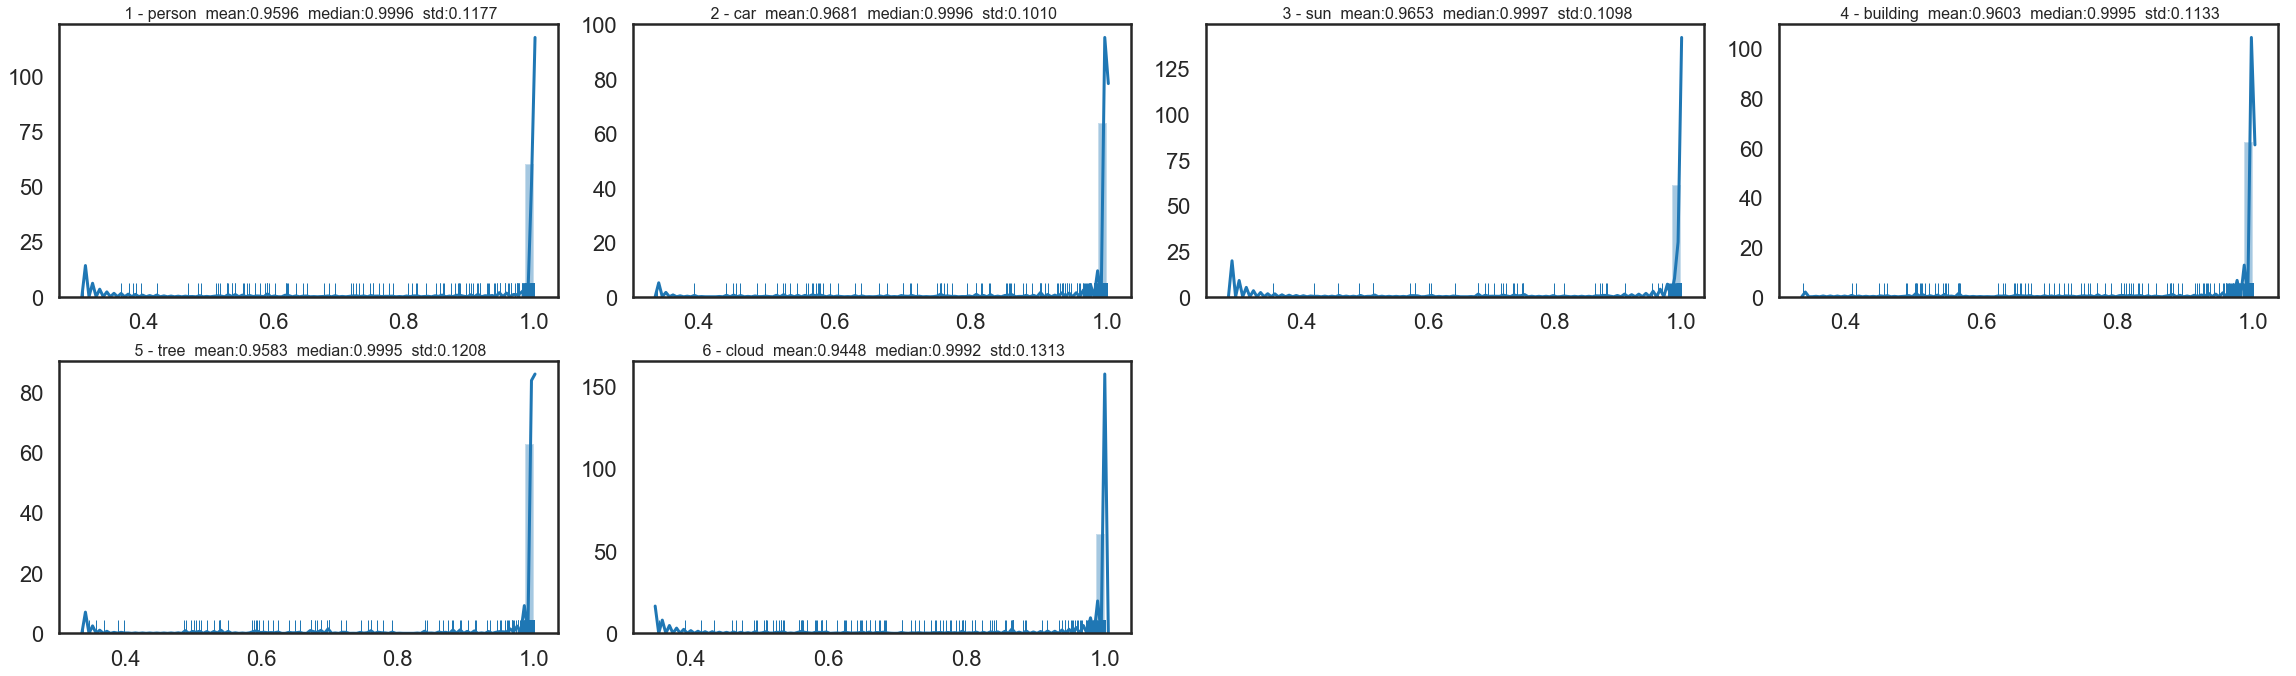

In [8]:
cmap.plot_score_distribution(cls_info, 'mrcnn_score_orig')

In [ ]:
plot_score_distribution(cls_info, 'mrcnn_score_norm')

In [ ]:
plot_score_distribution(cls_info, 'mrcnn_score_0')

In [ ]:
plot_score_distribution(cls_info, 'mrcnn_score_1')

In [ ]:
plot_score_distribution(cls_info, 'mrcnn_score_2')

In [ ]:
plot_score_distribution(cls_info, 'fcn_score_0')

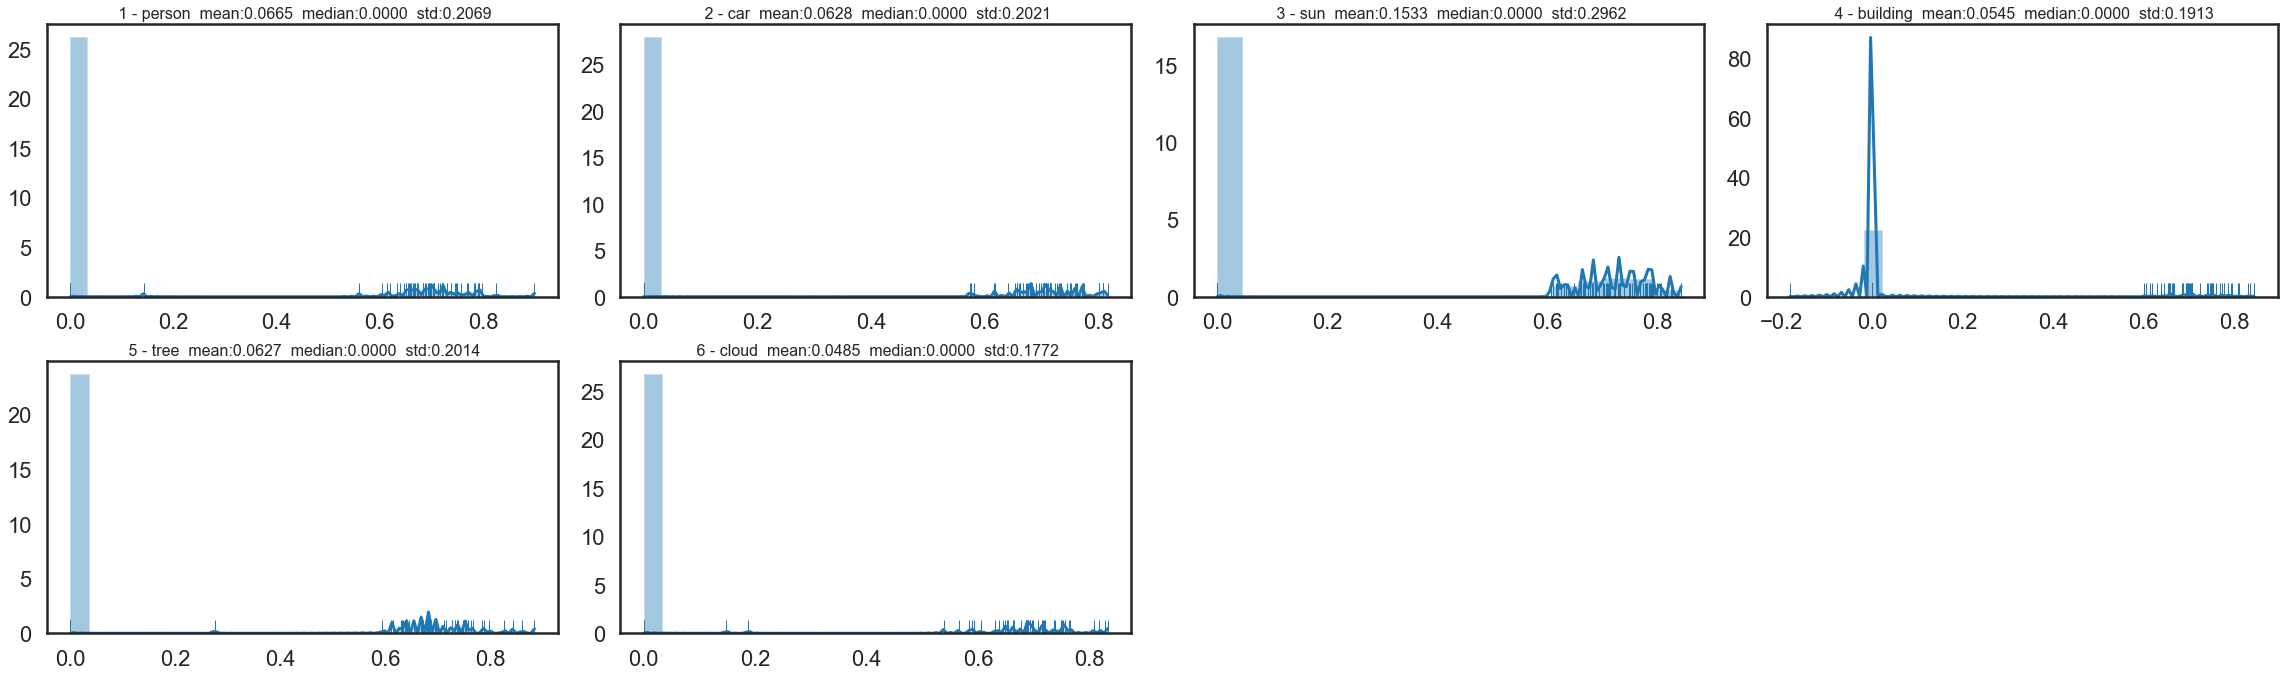

In [11]:
cmap.plot_score_distribution(cls_info, 'fcn_score_1')

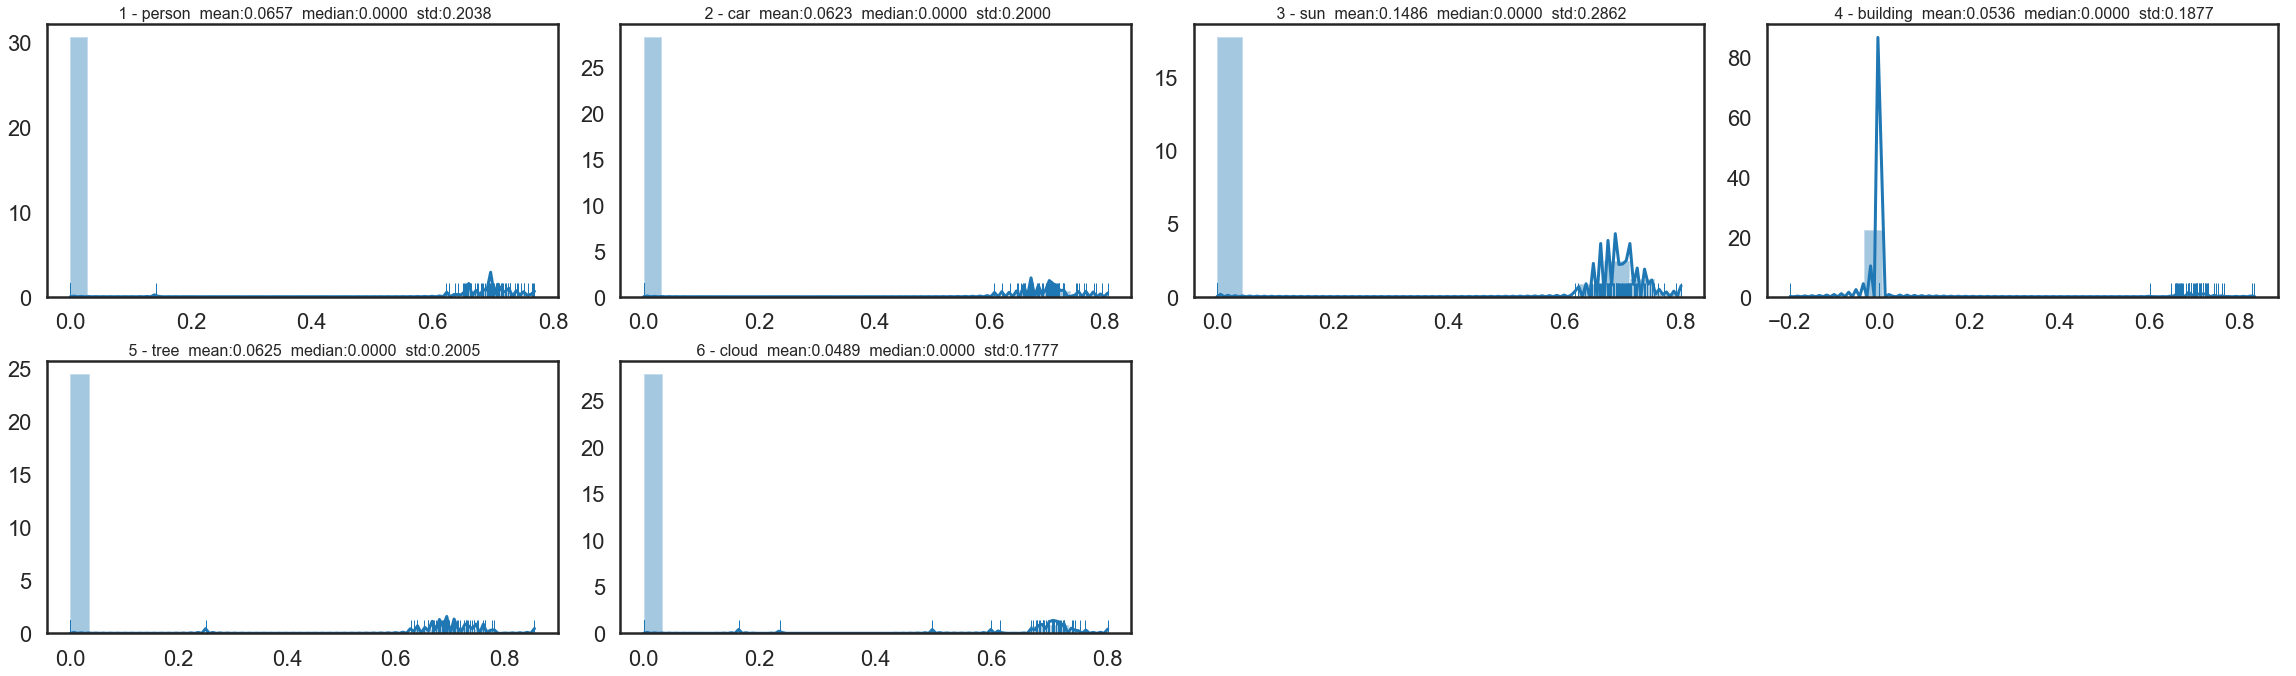

In [9]:
cmap.plot_score_distribution(cls_info, 'fcn_score_2')

#### display of gt_boxes_class, pr_boxes_class

In [ ]:
# gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 5)
gt_boxes_class, pr_boxes_class = filter_by_class_2(gt_boxes, pr_boxes, class_id= 2)
print(type(gt_boxes_class), type(pr_boxes_class))
pr_keys = list(pr_boxes_class.keys())
gt_keys = list(gt_boxes_class.keys())
print(len(gt_boxes.keys()), len(pr_boxes.keys()))
print(len(gt_keys), gt_keys[:10])
print(len(pr_keys), pr_keys[:10])
sel_gt_keys = gt_keys[:3]
sel_pr_keys = pr_keys[:3]
# pp.pprint(pr_boxes['newshapes_00002'])
for key in gt_keys[:3]:
    print('-----------------------')
    print('Key: ', key)
    print('-----------------------')
    pp.pprint(pr_boxes_class[key])
    print()
    pp.pprint(gt_boxes_class[key])

In [ ]:

# class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# Runs it for one IoU threshold


### Display mAP for one class and one threshold

In [ ]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes_class[cls], pr_boxes_class[cls], iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

### Display mAP one threshold (across all classes)

In [ ]:
cls = 1

iou_thr = 0.5
start_time = time.time()
data =  cmap.get_avg_precision_at_iou(gt_boxes, pr_boxes, iou_thr=iou_thr, score_key = 'scores')
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))
# pp.pprint(data)

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(' precisions: ', precisions.shape)
print(' recalls   : ', recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

## Barchart - AP vs. IoU Threshold for various scores 

 Num disp classes 1  Columns:  1  Rows:  1


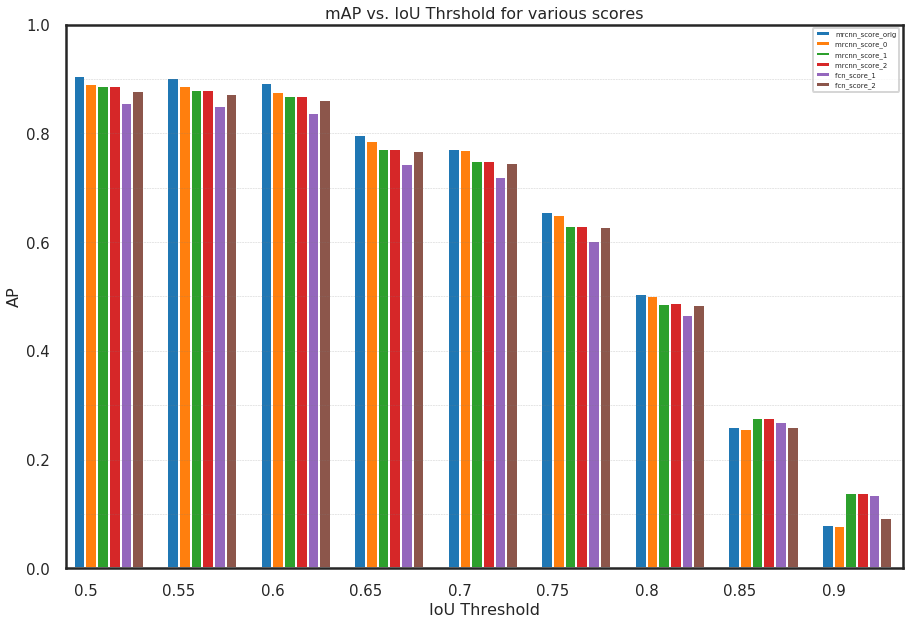


                                                  AP @ IoU Thresholds for computed scores                                                   

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Score -                           0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
--------------------------------------------------------------------------------------------------------------------------------------------
mrcnn_score_orig                  0.9054     0.9023     0.8921     0.7962     0.7720     0.6545     0.5049     0.2592     0.0799     %64.07 
mrcnn_score_0                     0.8912     0.8870     0.8771     0.7862     0.7696     0.6495     0.5010     0.2567     0.0780     %63.29 
mrcnn_score_1                     0.8869     0.8806     0.8689     0.7711     0.7500     0.6296     0.4871     0.2773     0.1381     %63.22 
mrcnn_score_2

In [4]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2',  'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
cmap.plot_mAP_vs_IoUs_BarChart(all_data, disp_scores, class_ids= [0])# , disp_ious)

## Barchart mAP vs. Class for different scores `plot_mAP_vs_class()`

disp_scores:  ['mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']


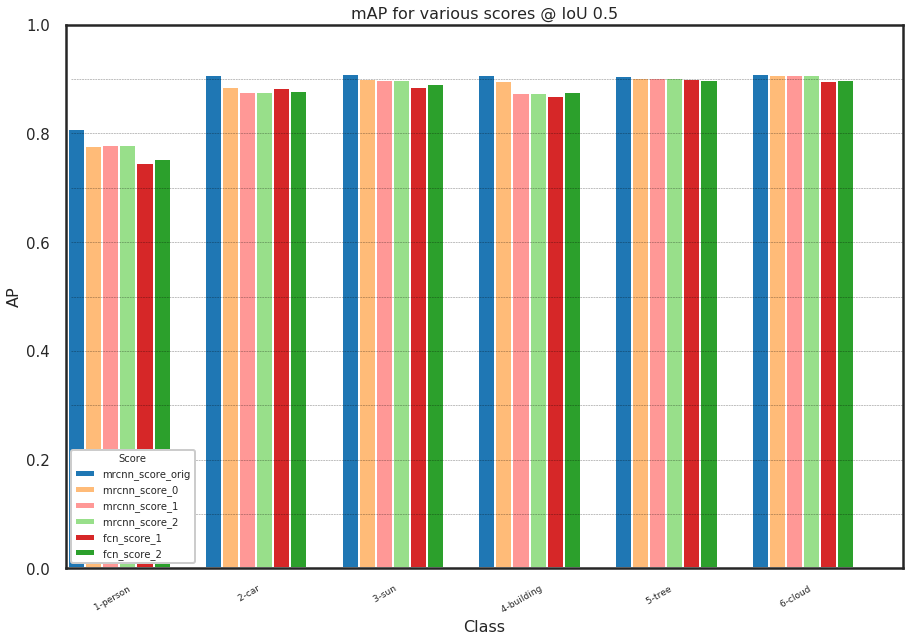


                                                AP @ IoU 0.50 Thresholds for Computed Scores                                                

-----------------------------------------------------------------  scores  -----------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_1       fcn_score_2
--------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8084            0.7774            0.7778            0.7785            0.7453            0.7531 
 2 - car                           0.9082            0.8852            0.8771            0.8771            0.8829            0.8781 
 3 - sun                           0.9091            0.9008            0.8976            0.8976            0.8847            0.8901 
 4 - building                      0.9071   

In [7]:
# disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']
disp_ious    = [0.5 , 0.75, 0.9]
# cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_ids= CLASS_IDS_SG1,class_names = CLASS_NAMES, iou = 0.5)
# cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_ids= CLASS_IDS_SG2,class_names = CLASS_NAMES, iou = 0.5)
cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_ids= CLASS_IDS,class_names = CLASS_NAMES, iou = 0.5)
# cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = CLASS_NAMES, iou = 0.5)
# cmap.plot_mAP_vs_class_BarChart(all_data, disp_scores, class_names = CLASS_NAMES, iou = 0.75)

## Plot combined mAP for different IoU thresholds for each score
(one type of score, e.g. 'scores' - all classes combined)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14

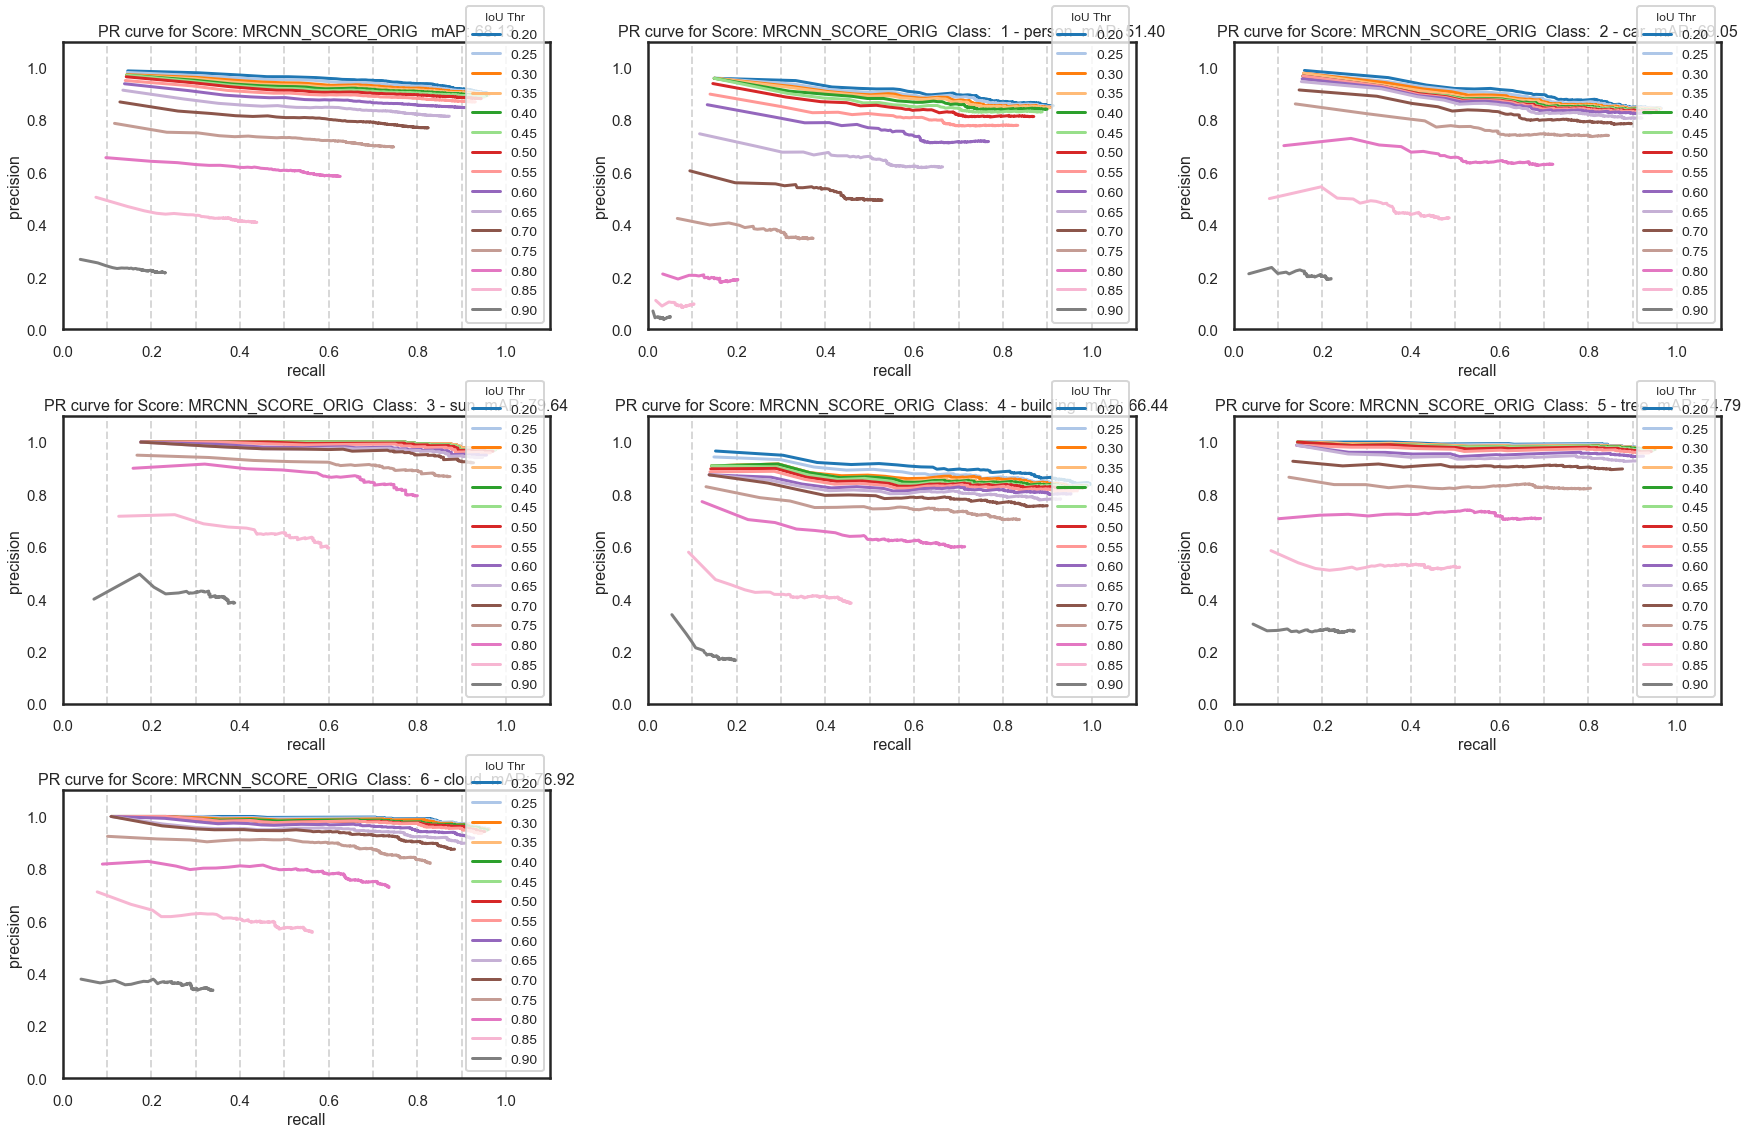

In [18]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig' , class_ids = None , class_names = CLASS_NAMES, columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )

cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0' , class_ids = 0 , class_names = class_names, columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_1' , class_ids = 0 ,class_names = class_names, columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2' , class_ids = 0 ,class_names = class_names, columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_norm' , class_ids = 0 ,class_names = class_names, columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_0' , class_ids = 0 , class_names = class_names,columns = 3)

In [ ]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1' , class_ids = 0 , class_names = class_names,columns = 3)

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9

                                           AP @ IoU Thresholds for Score Computation: fcn_score_2                                           

-------------------------------------------------------------  IoU Thresholds  -------------------------------------------------------------
Id - ClassName                    0.2000     0.2500     0.3000     0.3500     0.4000     0.4500     0.5000     0.5500     0.6000     0.6500     0.7000     0.7500     0.8000     0.8500     0.9000       mAP
----------------------------------------------------------------------------------------------------------------------------------

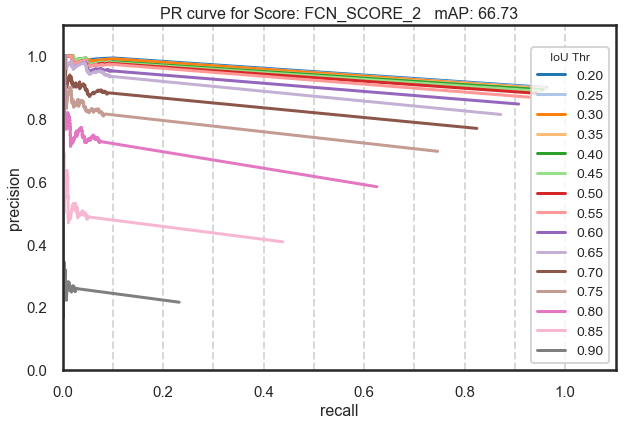

In [20]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2' , class_ids = 0 , class_names = CLASS_NAMES,columns = 2)

## Plot combined mAP info for different scores (at a given IoU threshold, all classes combined)

In [ ]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2' ,'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names,iou = 0.80)

In [ ]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names, iou = 0.85)

In [ ]:
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1',  'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = [0], class_names = class_names, iou = 0.75)

## Indvidual classes - Plot mAP info for  at different thresholds (one type of score, e.g. 'scores')

### Plot mAP for `mrcnn_score_orig`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14

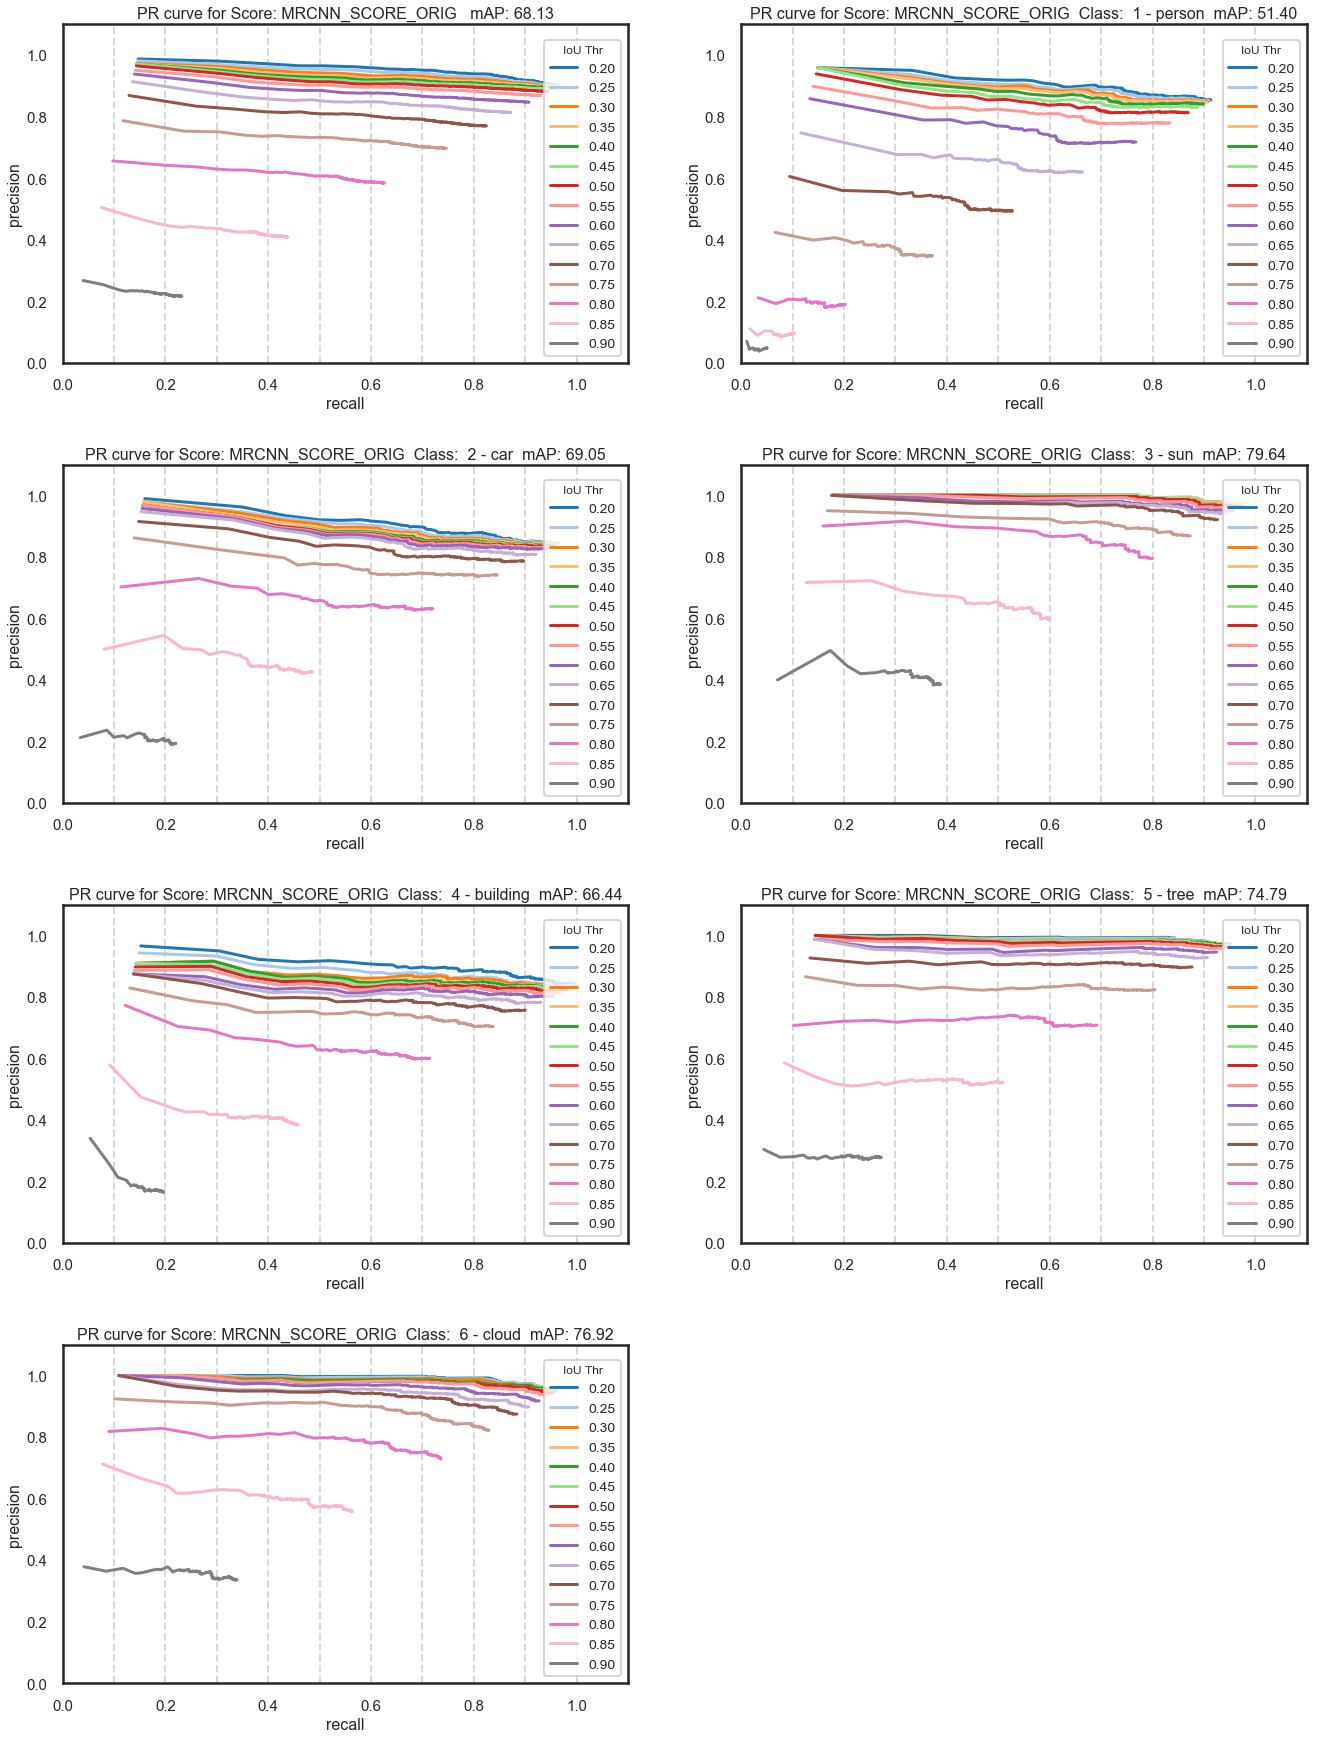

In [23]:
# plot_mAP_by_score(all_data, 'scores' )
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_orig', class_names = CLASS_NAMES , columns =2)

### Plot mAP for `mrcnn_score_norm`

In [ ]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_norm')

### Plot mAP for `mrcnn_score_0`

In [ ]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_0', class_names = class_names )

### Plot mAP for `mrcnn_score_1`

In [ ]:
plot_mAP_by_IOU(all_data, 'mrcnn_score_1', class_names = class_names )

### Plot mAP for `mrcnn_score_2`

In [ ]:
cmap.plot_mAP_by_IOU(all_data, 'mrcnn_score_2', class_names = class_names )

### Plot mAP for `fcn_score_1`

In [ ]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_1', class_names = class_names )

### Plot mAP for `fcn_score_2`

['ALL CLASSES', 'person', 'car', 'sun', 'building', 'tree', 'cloud']
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14 0.9
idx/iou_key:  0 0.2
idx/iou_key:  1 0.25
idx/iou_key:  2 0.3
idx/iou_key:  3 0.35
idx/iou_key:  4 0.4
idx/iou_key:  5 0.45
idx/iou_key:  6 0.5
idx/iou_key:  7 0.55
idx/iou_key:  8 0.6
idx/iou_key:  9 0.65
idx/iou_key:  10 0.7
idx/iou_key:  11 0.75
idx/iou_key:  12 0.8
idx/iou_key:  13 0.85
idx/iou_key:  14

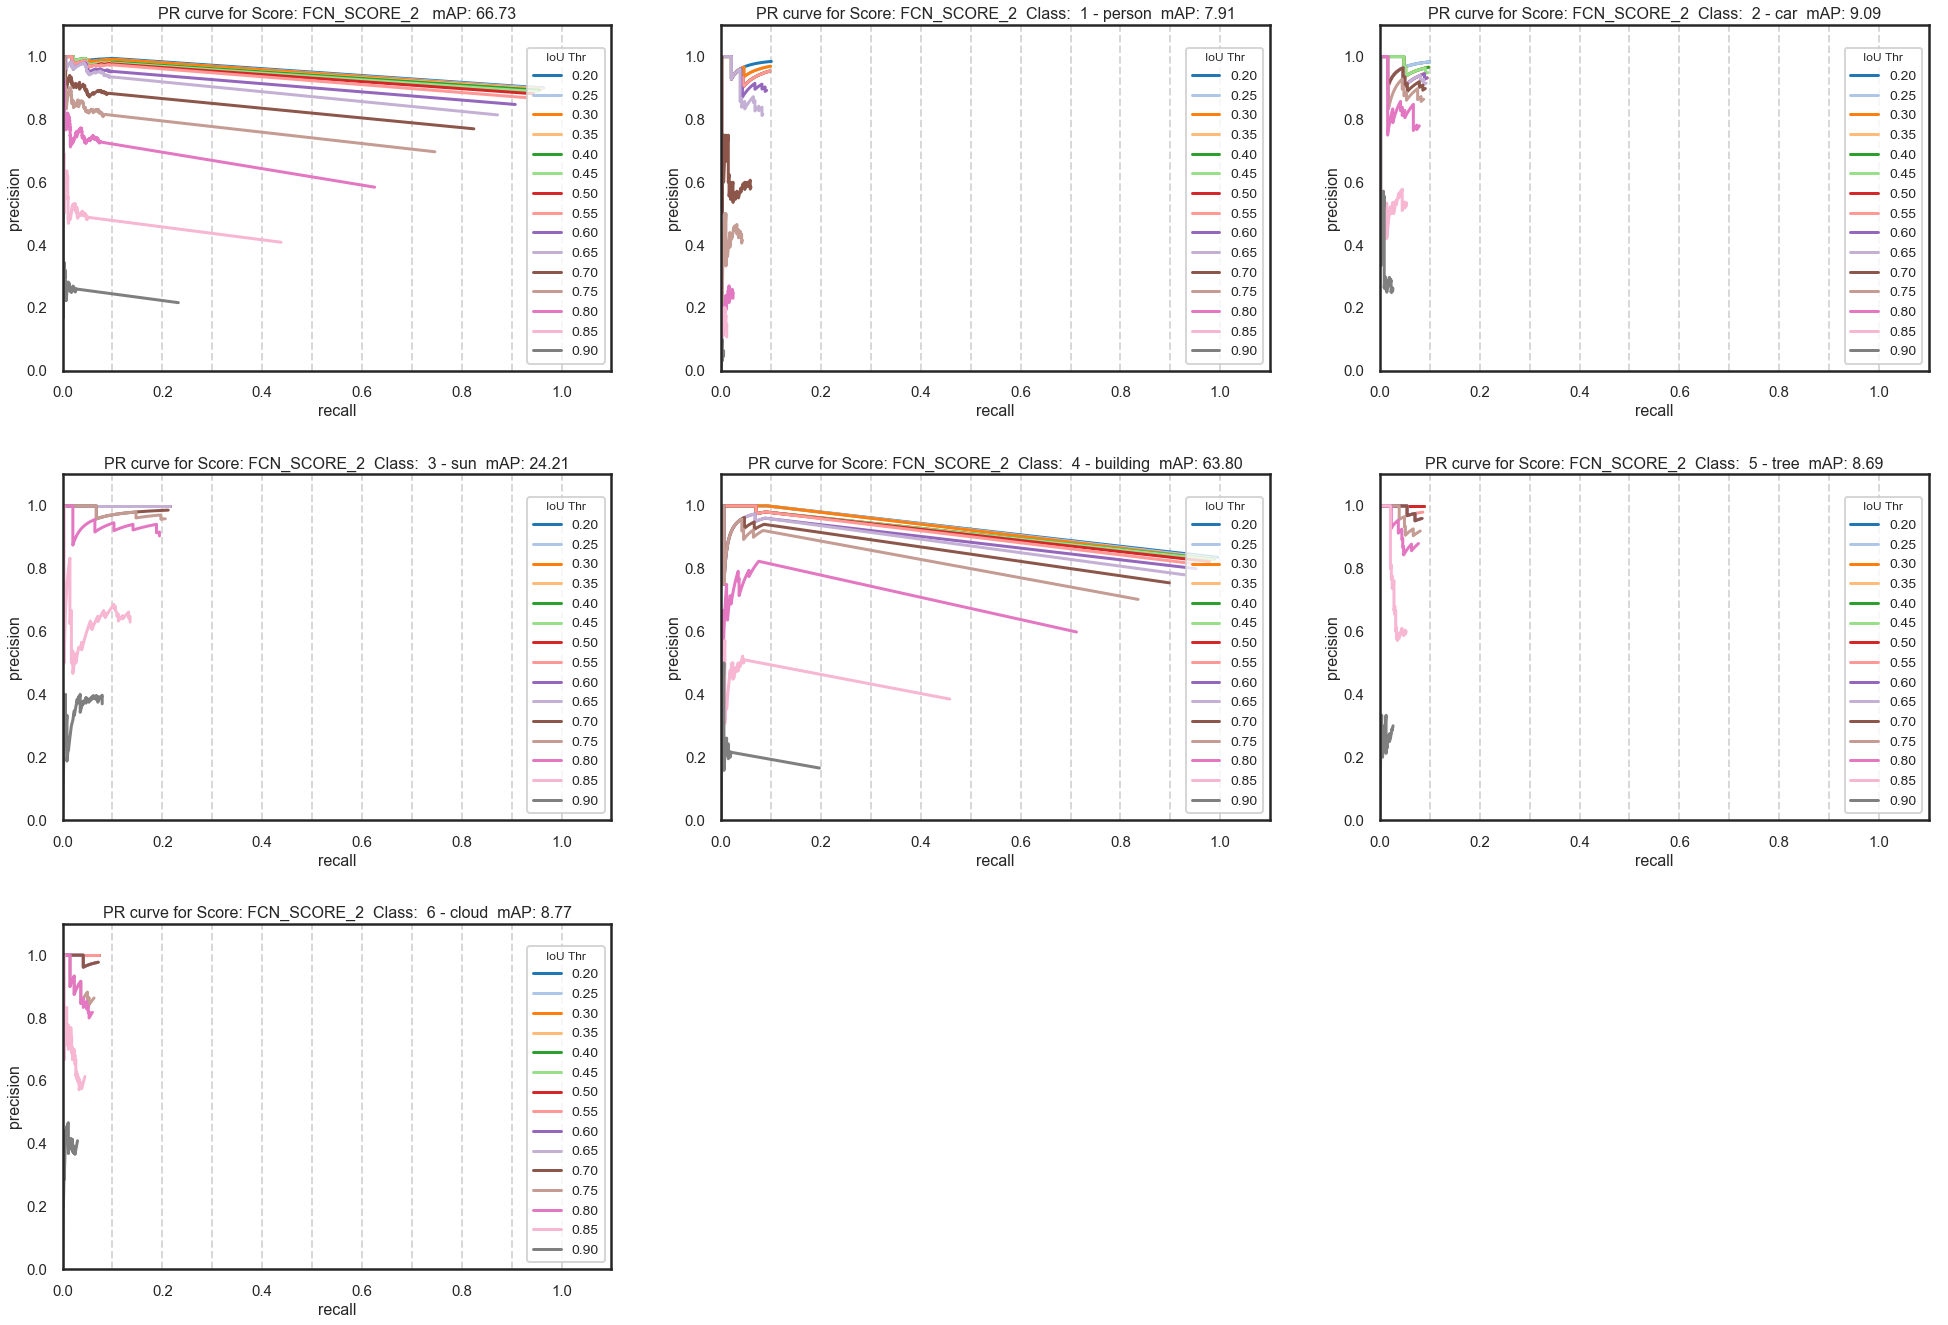

In [24]:
cmap.plot_mAP_by_IOU(all_data, 'fcn_score_2', class_names = CLASS_NAMES )

## Indvidual classes - Plot mAP info for different scores (at a given IoU threshold)

### IoU = 0.5

col/rows:  3 3

                                                     AP @ IoU 0.50 Thresholds for Computed Scores                                                     

----------------------------------------------------------------------  scores  ----------------------------------------------------------------------
Id - ClassName           mrcnn_score_orig     mrcnn_score_0     mrcnn_score_1     mrcnn_score_2       fcn_score_1       fcn_score_2
------------------------------------------------------------------------------------------------------------------------------------------------------
 1 - person                        0.8084            0.7774            0.7778            0.7785            0.7453            0.7531 
 2 - car                           0.9082            0.8852            0.8771            0.8771            0.8829            0.8781 
 3 - sun                           0.9091            0.9008            0.8976            0.8976            0.8847            0.8901 

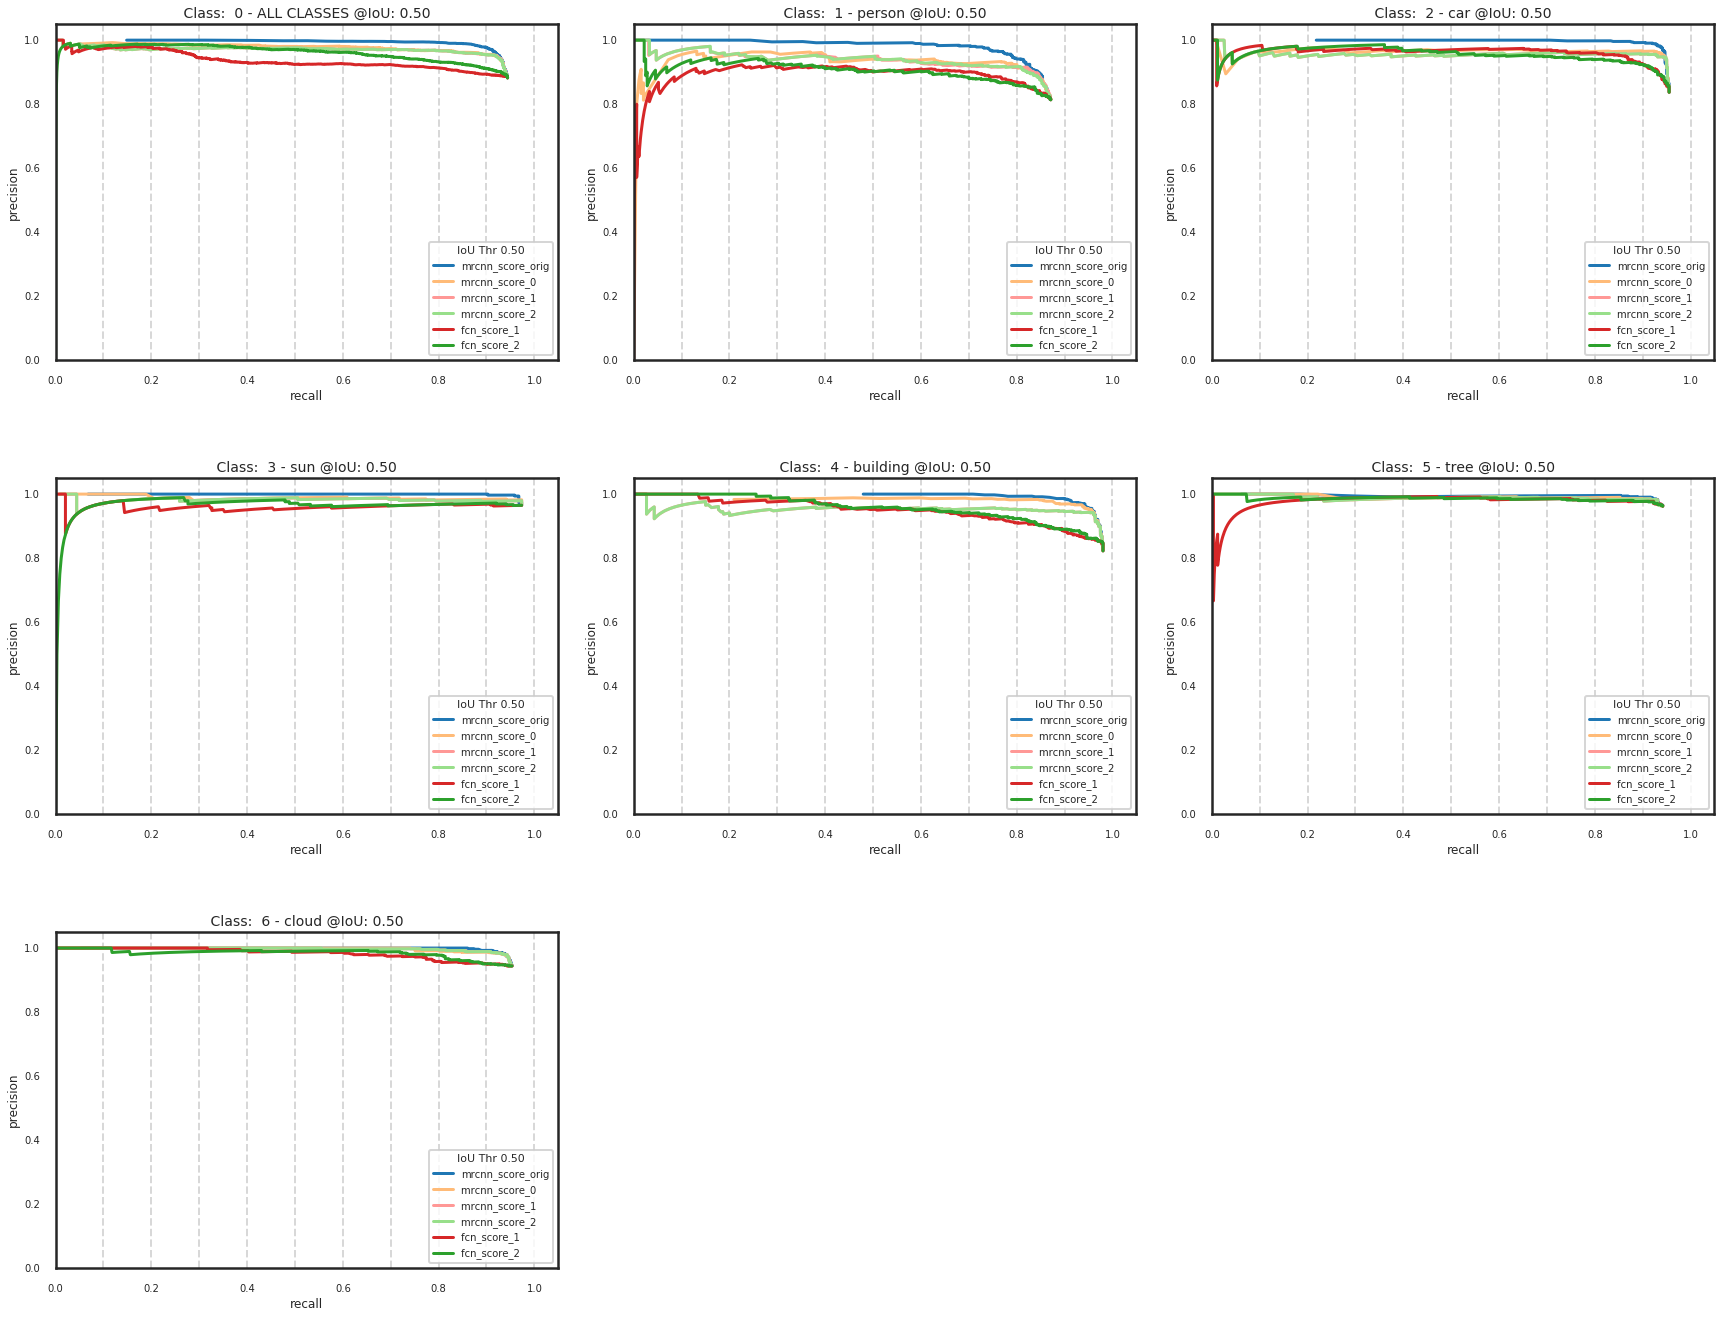

In [15]:
disp_classes = [0,1,2,3,4,5,6]
disp_scores  = [ 'mrcnn_score_orig', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_1', 'fcn_score_2']
cmap2.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= CLASS_NAMES, iou = 0.5, columns = 3)
# cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = CLASS_IDS_SG2, class_names= CLASS_NAMES, iou = 0.5, columns = 2)

###  Calculate information for one class at one  threshold with different scores, e.g. 'scores')

In [ ]:
disp_classes = [0,1,2,3,4,5,6]  
disp_scores  = [ 'mrcnn_score_orig' , 'mrcnn_score_norm', 'mrcnn_score_0', 'mrcnn_score_1', 'mrcnn_score_2', 'fcn_score_0', 'fcn_score_1', 'fcn_score_2']
cmap.plot_mAP_by_scores(all_data, scores = disp_scores, class_ids = disp_classes, class_names= class_names, iou = 0.75)

In [ ]:
# cls = 1
# for i in pr_boxes_class[cls]:
#     print(i)
#     print(pr_boxes_class[cls][i]['scores'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_orig'])
#     print(pr_boxes_class[cls][i]['mrcnn_score_norm'])
#     print('---------')

In [ ]:
pp.pprint(all_data[1].keys())

In [ ]:
# pp.pprint(all_data[1]['mrcnn_score_norm'])

In [ ]:
pp.pprint(all_data[1]['mrcnn_score_orig'])

In [ ]:
pp.pprint(all_data[1]['scores'])

In [ ]:
print(all_data[1]['mrcnn_score_0'])

In [ ]:
print(all_data[1]['mrcnn_score_1'])

In [ ]:
print(all_data[1]['mrcnn_score_2'])

In [ ]:
print(all_data[1]['scores'] == all_data[1]['mrcnn_score_orig'])

In [ ]:
for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
    print(idx, iou_thr, np.round(iou_thr,2))
for idx, iou_thr in enumerate(np.arange(0.5, 0.95, 0.05)):
    print(idx, iou_thr)    
for idx, iou_thr in enumerate(range(0.5, 0.95,  0.05)):
    print(idx, iou_thr)    

## Code from `calculate_mean_ap.py`

### `get_models_scores_map()`

In [ ]:
def get_model_scores_map(pred_boxes, score_key ):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for raw_score in val['scores']:
            score = round(raw_score,5)
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [ ]:
from copy import deepcopy
def get_avg_precision_at_iou(in_gt_boxes, in_pred_boxes, iou_thr=0.5, score_key = 'scores'):
    '''
    Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    '''
    gt_boxes = deepcopy(in_gt_boxes)
    pred_boxes = deepcopy(in_pred_boxes)
    model_scores_map    = get_model_scores_map(pred_boxes, score_key = score_key)
    sorted_model_scores = sorted(model_scores_map.keys())
    print('sorted_model_scores :' , sorted_model_scores)
    
    ## Sort the predicted boxes in ascending score order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        
        arg_sort = np.argsort(pred_boxes[img_id][score_key])
        print()
        print('image_id : ', img_id)
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        print('argsort:' , arg_sort)
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id][score_key])[arg_sort].tolist()
        pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()
        print('after')
        print('--------------------------')
        print('scores:', pred_boxes[img_id]['scores'] )
        print(score_key, ':' ,pred_boxes[img_id][score_key] )
        print(pred_boxes[img_id]['boxes'] )
        
        
    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions  = []
    recalls     = []
    model_thrs  = []
    img_results = {}
    
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        print('------------------------------------------------')
        print('ithr ', ithr, 'model_scr_thr', model_score_thr)
        print('------------------------------------------------')
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]['boxes']
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
#                     pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break
            print('Start Idx is ', start_idx)
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']  = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = cmap.get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)
            print('image_id : ', img_id)
            print('--------------------------')            
            pp.pprint(gt_boxes_img)
            pp.pprint(pred_boxes_pruned[img_id]['boxes'])
            pp.pprint(img_results[img_id])
            print()
        prec, rec = cmap.calc_precision_recall(img_results)
        print('precision:', prec, 'Recall:', rec)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    print('final precsions:', precisions)
    print('final recall   :', recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


In [ ]:
class_ids = [1,2,3,4,5,6]
## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
print(gt_boxes_class.keys())    
print(pr_boxes_class.keys())    
print(gt_boxes_class[1]['newshapes_00992'].keys())


In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
# msm = get_model_scores_map(pr_boxes_class[1], score_key = 'scores') 
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

print()

print(pr_boxes['newshapes_00992']['class_ids'])
print(pr_boxes['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes['newshapes_00992']['scores'])
print(pr_boxes['newshapes_00992']['boxes'])

In [ ]:
data1 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data1)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data2 = get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data2)

In [ ]:
print(data1)
print(data2)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data3 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_orig')
print(data3)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])

In [ ]:
data4 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'scores')
print(data4)

In [ ]:
data5 = cmap.get_avg_precision_at_iou(gt_boxes_class[1], pr_boxes_class[1], iou_thr= 0.5, score_key = 'mrcnn_score_norm')
print(data5)

In [ ]:
print(data3)
print(data4)
print(data5)

In [ ]:
print(pr_boxes_class[1].keys())
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_norm'])
print(pr_boxes_class[1]['newshapes_00992']['mrcnn_score_orig'])
print(pr_boxes_class[1]['newshapes_00992']['scores'])
print(pr_boxes_class[1]['newshapes_00992']['boxes'])
print(pr_boxes_class[1]['newshapes_00992']['det_ind'])
print(gt_boxes_class[1]['newshapes_00992']['boxes'])